#  Прогнозирование заказов такси

Исследование содержит данные компании о заказах такси в аэропортах. Основная задача — разработать модель для прогноза количества заказов такси на следующий час на основе имеющихся данных.

**Цель исследования:**

Построить модель машинного обучения для точного предсказания количества заказов такси на следующий час.

Таким образом, исследование пройдёт в **пять этапов**:
1) Обзор данных
2) Исследовательский анализ данных
3) Создание признаков
4) Обучение моделей
5) Анализ результатов. Тестирование лучшей модели

**Описание данных:**
- `datetime` — дата и время заказа.
- `num_orders` — количество заказов.

## Загрузка и импорт библиотек

In [1]:
# # Загрузка необходимых библиотек
# !pip install optuna
# !pip install lightgbm
# !pip install optuna-integration[sklearn]
# !pip install -U scikit-learn
# !pip install matplotlib==3.8.0
# !pip install seaborn --upgrade

In [2]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import optuna
import lightgbm as lgb
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from optuna.integration import OptunaSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='muted')

In [3]:
def data_info (df):
    '''
    Отображает первые 5 строк, общую информацию, описательную статистику DataFrame,
    количество пропущенных значений и явных дубликатов.

    '''
    display(df.head())
    df.info()
    display(df.describe().round(3))
    print('Количество пропусков:',
          df.isna().sum(), sep='\n', end='\n\n')
    print('Количество дубликатов:', 
          df.duplicated().sum())

## Загрузка и обзор данных

In [4]:
# Загрузка данных
try:
    taxi = pd.read_csv('taxi.csv', parse_dates=['datetime'])
except:
    taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])

In [5]:
# Вывод общей информации о датафрейме
data_info(taxi)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


,datetime,num_orders
count,26496,26496.000
mean,2018-05-31 23:55:00,14.070
min,2018-03-01 00:00:00,0.000
25%,2018-04-15 23:57:30,8.000
50%,2018-05-31 23:55:00,13.000
75%,2018-07-16 23:52:30,19.000
max,2018-08-31 23:50:00,119.000
std,NaN,9.211


Количество пропусков:
datetime      0
num_orders    0
dtype: int64

Количество дубликатов: 0


Установим временную компоненту (столбец `datetime`) в качестве индекса:

In [6]:
# Установка столбца 'datetime' в качестве индекса
taxi.set_index('datetime', inplace=True)
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
# Проверка индекса на монотонность
print(f'Упорядочены ли данные - {"Да" if taxi.index.is_monotonic_increasing else "Нет"}')

Упорядочены ли данные - Да


In [8]:
# Ресемплирование по 1 часу
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Общая предварительная оценка данных:**
- Набор данных достаточен для исследовательского анализа.
- Датафрейм содержит 26 496 строк с информацией о заказах такси в аэропортах. Данные представлены с 01.03.2018 по 31.08.2018.
- В данных отсутствуют пропущенные значения и дубликаты.
- Даты и время упорядочены.
- Провели ресемплирование данных по одному часу.

## Исследовательский анализ данных

### Распределение количества заказов

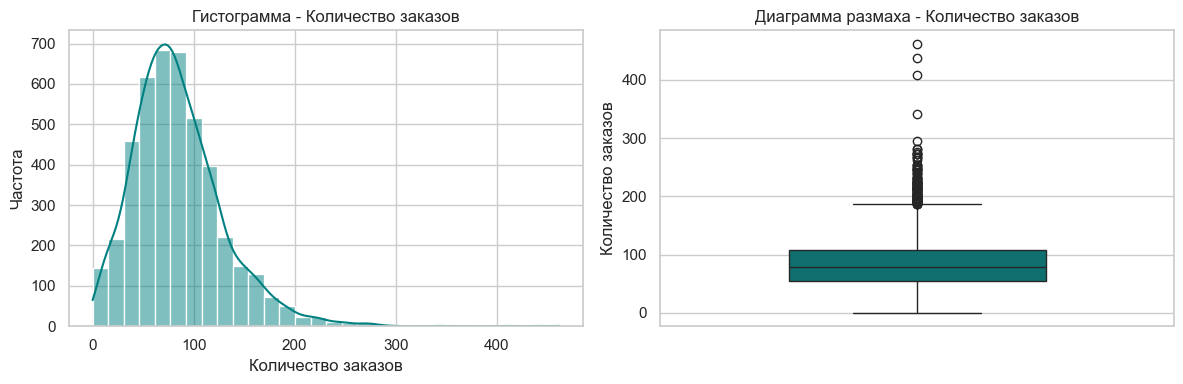

Описательные статистики:


,count,mean,std,min,25%,50%,75%,max
num_orders,4416.000,84.423,45.024,0.000,54.000,78.000,107.000,462.000


In [9]:
# Построение графиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    
 # Гистограмма
sns.histplot(data=taxi, x='num_orders', bins=30, ax=ax1, kde=True, color='teal')
ax1.set_title(f'Гистограмма - Количество заказов')
ax1.set_xlabel('Количество заказов')
ax1.set_ylabel('Частота')

# Диаграмма размаха
sns.boxplot(data=taxi, y='num_orders', ax=ax2, width=.5, color='teal')
ax2.set_title(f'Диаграмма размаха - Количество заказов')
ax2.set_ylabel('Количество заказов')

plt.tight_layout()
plt.show()

# Описательные статистики
print(f'Описательные статистики:')
try:
    display(pd.DataFrame(taxi['num_orders'].describe()).T.style.set_precision(3))
except:
    display(pd.DataFrame(taxi['num_orders'].describe()).T.style.format(precision=3))

На гистограмме наблюдаем смещенное нормальное распределение. Медианное значение заказов такси в час составляет **84**. 

По диаграмме размаха видим, что количество заказов/час более 200 обозначены как выбросы, т.е. встречается крайне редко. Однако эти значения не являются ошибочными или аномальными, лишь указывают на пиковые часы.

Рассмотрим временной ряд с **различными интервалами** (час, неделя, месяц):

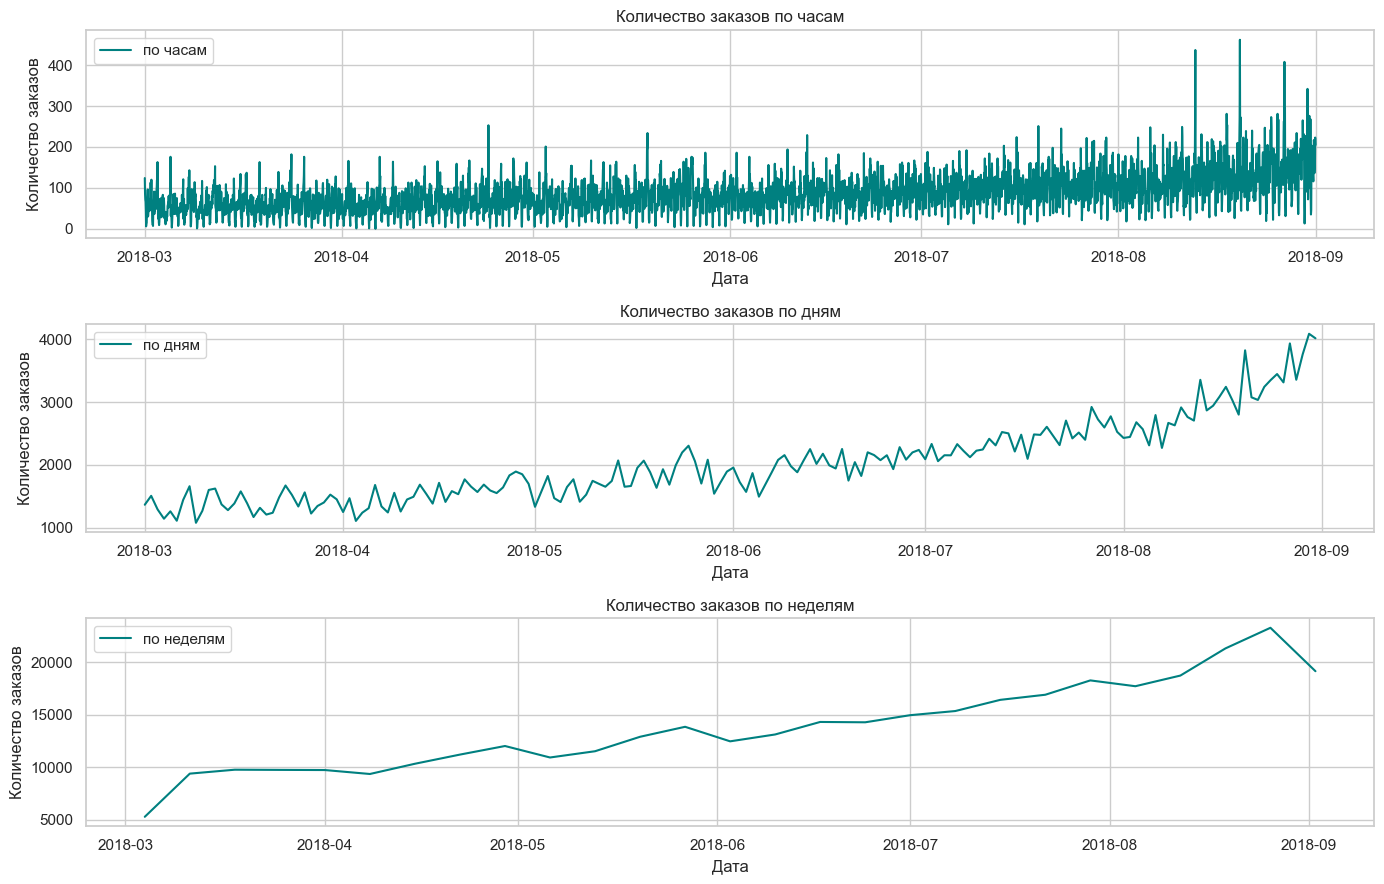

In [10]:
# Ресемплирование по дням, неделям
taxi_daily = taxi['num_orders'].resample('1D').sum()
taxi_weekly = taxi['num_orders'].resample('1W').sum()

# Данные для графиков и подписи
orders_for_plot = [
    (taxi['num_orders'], 'по часам'), 
    (taxi_daily, 'по дням'), 
    (taxi_weekly, 'по неделям')
]

plt.figure(figsize=(14, 9))

# Графики количества заказов с ресемплированием
for i, (df, title) in enumerate(orders_for_plot, 1):
    plt.subplot(3, 1, i)
    sns.lineplot(x=df.index, y=df, label=title, color='teal')
    plt.title(f'Количество заказов {title}')
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов')

plt.tight_layout()
plt.show()

- **По часам**. Видны высокочастотные колебания. Количество заказов колеблется от часа к часу, к концу периода наблюдается рост (июль-август).
- **По дням**. Заметен уже более явный рост с течением времени. С марта по июль количество заказов стабильно увеличивается, а с июля наблюдается значительное увеличение. Объяснить это можно пиком туристического сезона. В летние месяцы полеты совершаются намного чаще, следовательно большему количеству людей требуются услуги такси.
- **По неделям**. Увеличение количества заказов наблюдается еще более явно. К концу августа количество заказов достигает пика, после чего происходит незначительное снижение.

### Декомпозиция временного ряда

Для более детального анализа временного ряда, декомпозируем его на **тренд, сезонность и остатки**.

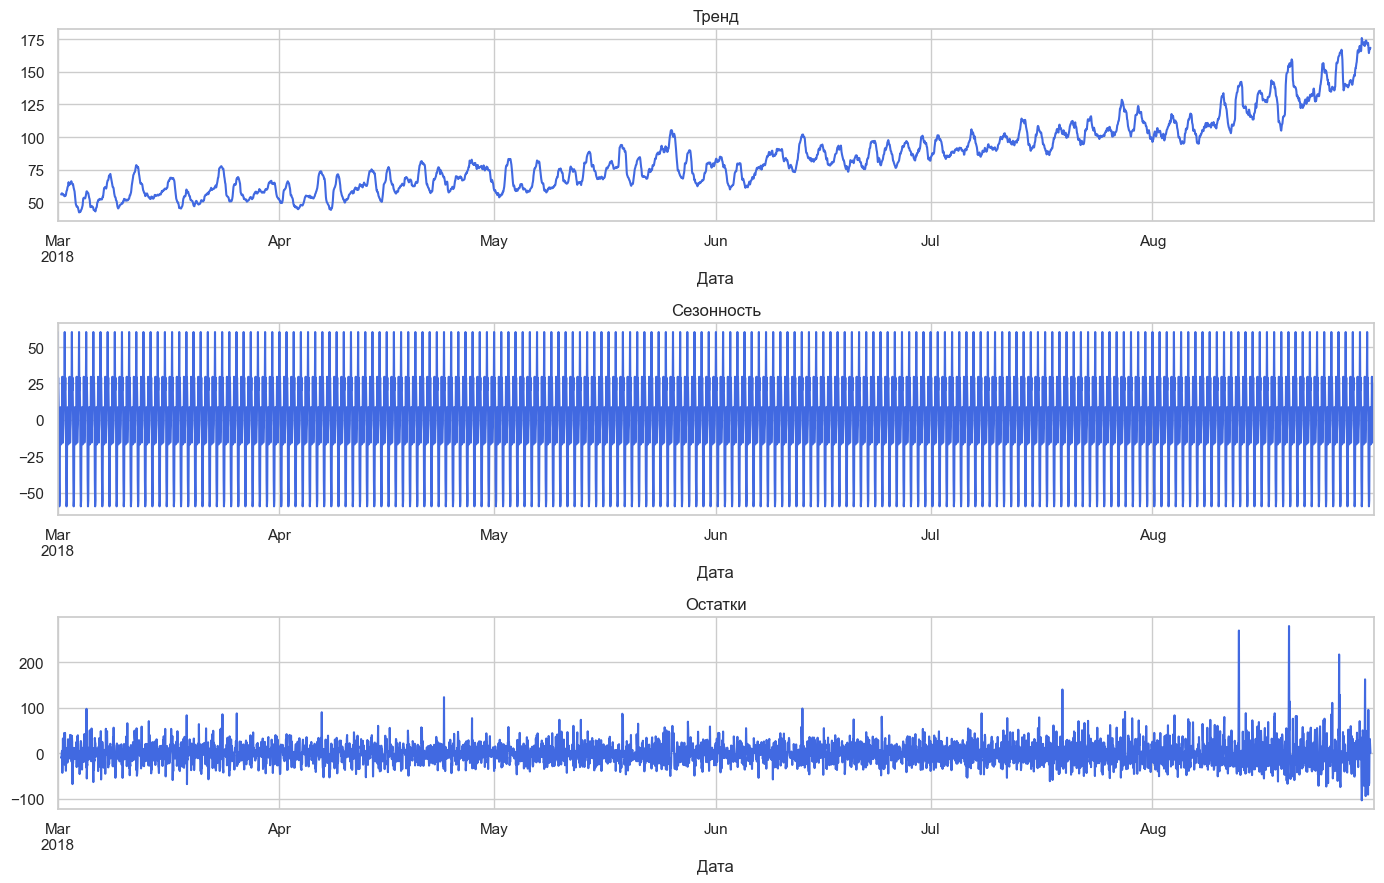

In [11]:
# Декомпозиция временного ряда
taxi_decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(14, 9))

# График 'Тренд'
plt.subplot(311)
taxi_decomposed.trend.plot(ax=plt.gca(), color='royalblue')
plt.title('Тренд')
plt.xlabel('Дата')

# График 'Сезонность'
plt.subplot(312)
taxi_decomposed.seasonal.plot(ax=plt.gca(), color='royalblue')
plt.title('Сезонность')
plt.xlabel('Дата')

# График 'Остатки'
plt.subplot(313)
taxi_decomposed.resid.plot(ax=plt.gca(), color='royalblue')
plt.title('Остатки')
plt.xlabel('Дата')

plt.tight_layout()
plt.show()

- **Тренд**: С марта по май значения стабильны и колеблятся в диапазоне 50-75 заказов. С мая по август наблюдается планомерный рост до 100-125 заказов. В агусте виден резкий рост до значений в 150-175 заказов.

- **Сезонность**: Из-за размера интервала выявить сезонные закономерности на графике затруднительно. Рассмотрим сезонность в рамках меньшего интервала: 1 недели и 3 дней.

- **Остатки**: это случайные колебания, которые не объясняются трендом или сезонностью. На графике явно выделяются несколько пиков в конце августа. Рассмотрим их подробнее.

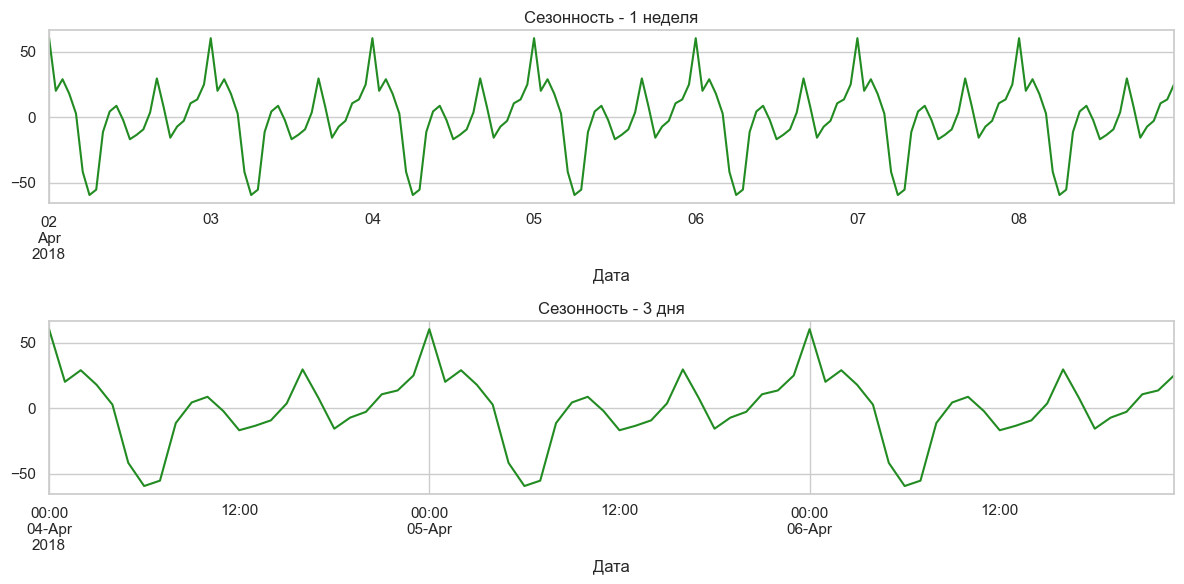

In [12]:
# График 'Сезонность за неделю'
plt.figure(figsize=(12, 6))
plt.subplot(211)
taxi_decomposed.seasonal['2018-04-02':'2018-04-08'].plot(ax=plt.gca(), color='forestgreen')
plt.title('Сезонность - 1 неделя')
plt.xlabel('Дата')

#График 'Сезонность за  3 дня'
plt.subplot(212)
taxi_decomposed.seasonal['2018-04-04':'2018-04-06'].plot(ax=plt.gca(), color='forestgreen')
plt.title('Сезонность - 3 дня')
plt.xlabel('Дата')

plt.tight_layout()
plt.show()

На графике с интервалом в **1 неделю** четко видим, что колебания повторяются каждый день. 

В разрезе **3 дней** более четко можно рассмотреть, как количество заказов меняется в зависимости от времени суток. Пик заказов приходится на ночное время (около полуночи). Далее до 05:00 количество снижается. Самое минимальное количество заказов  - в диапазоне 05:00-07:00. Далее снова рост (до 11:00), после чего следующий пик приходится на 16:00-17:00.

Далее рассмотрим детальнее пиковые значения на графике **Остатки** в конце августа:

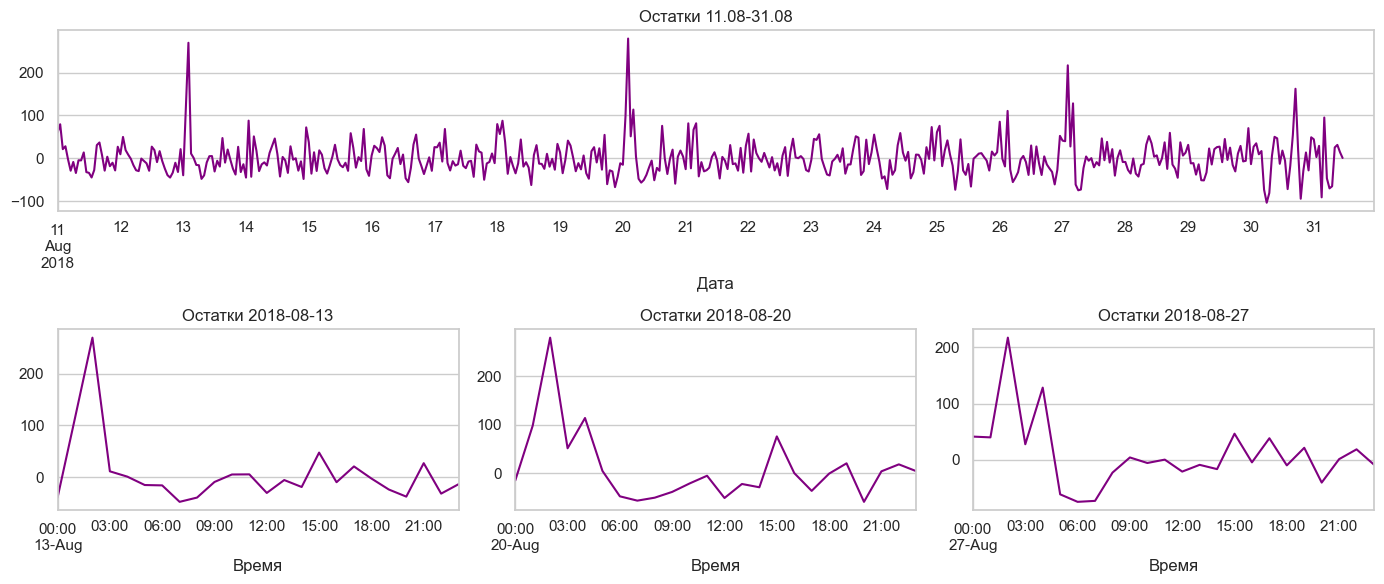

In [13]:
# График 'Остатки'
plt.figure(figsize=(14, 6))

# График остатков за 11.08 - 31.08
plt.subplot2grid((2, 3), (0, 0), colspan=3)
taxi_decomposed.resid['2018-08-11':'2018-08-31'].plot(ax=plt.gca(), color='purple')
plt.title('Остатки 11.08-31.08')
plt.xlabel('Дата')

# Даты для графиков по дням
resid_dates = ['2018-08-13', '2018-08-20', '2018-08-27']

# Графики по дням
for i, date in enumerate(resid_dates, 1):
    plt.subplot(2, 3, i + 3) 
    taxi_decomposed.resid[date].plot(ax=plt.gca(), color='purple')
    plt.title(f'Остатки {date}')
    plt.xlabel('Время')

plt.tight_layout()
plt.show()

На первом графике ярко выделяются 3 пиковых значения - 13, 20 и 27 августа (все дни - понедельники). 

На нижних графиках видим, что во всех днях пик приходится на одно и то же время - 01:00-02:00, т.е. ночью с воскресенья на понедельник. Август - конец туристического сезона и многие отдыхающие возвращаются из поездок в конце выходных (перед началом новой рабочей недели). Этим и можно объяснить данные пики на графиках.

### Проверка на стационарность

Проанализируем скользящее среднее и скользящее стандартное отклонение:

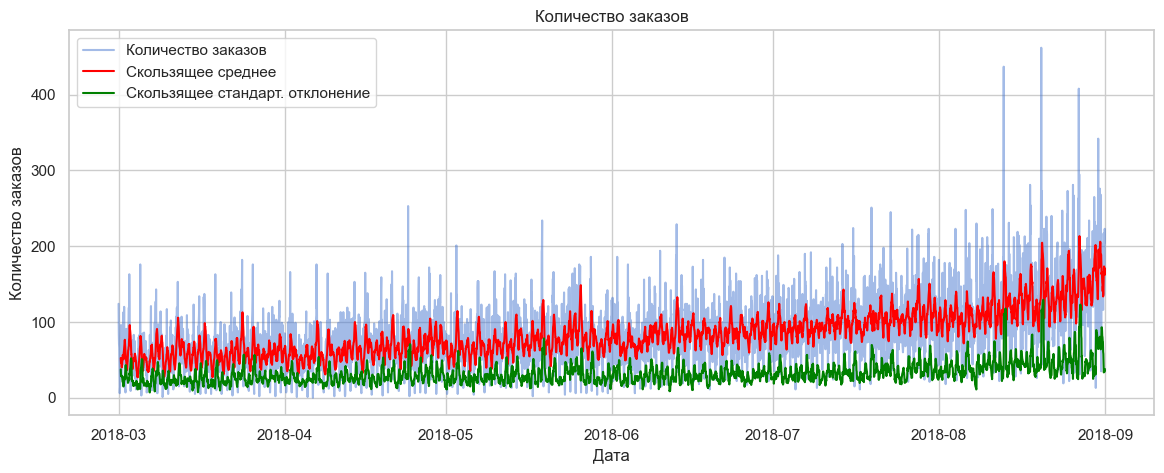

In [14]:
# Копия датафрейма
taxi_analis = taxi.copy()

# Расчет скользяшего среднего и стандартного отклонения
taxi_analis['rolling_mean'] = taxi_analis['num_orders'].shift(1).rolling(10).mean()
taxi_analis['rolling_std'] = taxi_analis['num_orders'].shift(1).rolling(10).std()

# График
plt.figure(figsize=(14, 5))
sns.lineplot(x=taxi_analis.index, y=taxi_analis['num_orders'], label='Количество заказов', alpha=0.5)
sns.lineplot(x=taxi_analis.index, y=taxi_analis['rolling_mean'], label='Скользящее среднее', color='red')
sns.lineplot(x=taxi_analis.index, y=taxi_analis['rolling_std'], label='Скользящее стандарт. отклонение', color='green')
plt.title('Количество заказов')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

- Скользящее среднее показывает восходящий тренд, особенно заметный в последние месяцы. Это свидетельствует о том, что среднее значение временного ряда увеличивается с течением времени.

- Скользящее стандартное отклонение на протяжении практически всего ряда стабильно, однако с июля заметно увеличивается. Это говорит о том, что разброс данных со временем становится больше.

Для более точной проверки стационарности будем использовать статистический **Тест Дики-Фуллера (ADF)**.Сформулируем гипотезы:
- Нулевая гипотеза (H₀): Временной ряд нестационарен.
- Альтернативная гипотеза (H₁): Временной ряд стационарен.

Если p-value окажется меньше 0.05, это будет означать, что ряд стационарен, и мы можем отвергнуть нулевую гипотезу.

In [15]:
# ADF тест
adf_result = adfuller(taxi['num_orders'])
print(f'ADF статистика: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

if adf_result[1] < 0.05:
    print('Стационарный ряд')
else:
    print('Нестационарный ряд')

ADF статистика: -3.0689242890279482
p-value: 0.028940051402613506
Стационарный ряд


**Выводы**:
- Распределение заказов такси в час смещенное нормальное, с медианным значением в 84 заказа. Значения выше 200 заказов/час встречаются редко, но не являются аномальными — они указывают на пиковые часы спроса.
- С марта по май количество заказов стабильно и колеблется в диапазоне 50-75 заказов. С мая по август наблюдается планомерный рост до 100-125 заказов. В агусте резкий рост до значений в 150-175 заказов.
- В течение дня пиковые значения заказов приходятся на ночь (01:00-02:00).
- Выделены случайные колебания в конце августа, вероятно, из-за увеличения числа туристов.
- Проведен тест Дики-Фуллера (ADF), который подтвердил стационарность временного ряда.

## Создание признаков

Создадим признаки для дальнейшего прогнозирования: календарные, лаговые и цикличные признаки, а также скользящие средние.

In [16]:
def make_features(df, target_col, max_lag, rolling_mean_list):
    '''
    Создает признаки временного ряда для датафрейма.
    
    Args:
        df(pd.DateFrame): Датафрейм с временным рядом.
        target_col (str): Целевой признак.
        max_lag (int): Максимальный размер лага.
        rolling_mean_list (list): Список со значениями ширины окна.
    '''
    # Копия датафрейма
    df_with_features = df.copy()
    
    # Календарные признаки
    df_with_features['day_of_week'] = df_with_features.index.dayofweek
    df_with_features['hour'] = df_with_features.index.hour

    # Синус и косинус для часов
    hours_in_day = 24
    df_with_features['hour_sin'] = np.sin(2 * np.pi * df_with_features['hour'] / hours_in_day)
    df_with_features['hour_cos'] = np.cos(2 * np.pi * df_with_features['hour'] / hours_in_day)

    # Лаги
    for lag in range(1, max_lag + 1):
        df_with_features[f'lag_{lag}'] = df_with_features[target_col].shift(lag)

    # Скользяшие средние
    for roll in rolling_mean_list:
        df_with_features[f'rolling_mean_{roll}'] = df_with_features[target_col].shift().rolling(roll).mean()

    # Удаление NAN значений
    df_with_features.dropna(inplace=True)

    return df_with_features

In [17]:
# Создание признаков для 'taxi'
taxi_with_features = make_features(taxi, 'num_orders', max_lag=24, 
              rolling_mean_list=[3, 6, 12, 24, 48])

# Проверка результатов
taxi_with_features.head()

,num_orders,day_of_week,hour,hour_sin,hour_cos,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_3,rolling_mean_6,rolling_mean_12,rolling_mean_24,rolling_mean_48
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,5,0,0.000000,1.000000,72.0,119.0,101.0,93.0,49.0,...,20.0,64.0,75.0,120.0,90.0,97.333333,87.166667,72.666667,62.750000,59.791667
2018-03-03 01:00:00,108,5,1,0.258819,0.965926,163.0,72.0,119.0,101.0,93.0,...,11.0,20.0,64.0,75.0,120.0,118.000000,99.500000,83.250000,65.791667,60.604167
2018-03-03 02:00:00,25,5,2,0.500000,0.866025,108.0,163.0,72.0,119.0,101.0,...,11.0,11.0,20.0,64.0,75.0,114.333333,109.333333,88.500000,65.291667,61.083333
2018-03-03 03:00:00,64,5,3,0.707107,0.707107,25.0,108.0,163.0,72.0,119.0,...,7.0,11.0,11.0,20.0,64.0,98.666667,98.000000,86.916667,63.208333,60.125000
2018-03-03 04:00:00,44,5,4,0.866025,0.500000,64.0,25.0,108.0,163.0,72.0,...,46.0,7.0,11.0,11.0,20.0,65.666667,91.833333,87.333333,63.208333,60.083333


**Выводы**:

В результате было создано 35 признаков временного ряда:
- Календарные: 'month', 'day_of_week', 'hour'.
- Лаговые: 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24'.
- Цикличные (представление часов как циклов): 'hour_sin', 'hour_cos'.
- Скользящие средние за 3, 6, 12, 24  и 48 часов: 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12','rolling_mean_24', 'rolling_mean_48'.

## Подготовка данных

Разделим датафрейм на тренировочную (90% данных) и тестовую (10% данных) выборки. Также выделим количественные признаки для масштабирования.

In [18]:
# Объявление констант
RANDOM_STATE = 42

# Разделение на целевой и входные признаки
X = taxi_with_features.drop(['num_orders'], axis=1)
y = taxi_with_features['num_orders']

# Разделение данных на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=0.1
)

# Размерность выборок
print('Размер тренировочной выборки:', X_train.shape, y_train.shape)
print('Размер тестовой выборки:', X_test.shape, y_test.shape)

Размер тренировочной выборки: (3931, 33) (3931,)
Размер тестовой выборки: (437, 33) (437,)


In [19]:
# Определение числовых признаков
num_columns = X.select_dtypes(include='number').columns
num_columns

Index(['day_of_week', 'hour', 'hour_sin', 'hour_cos', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12',
       'rolling_mean_24', 'rolling_mean_48'],
      dtype='object')

Для подготовки данных к обучению создадим **pipeline**. Масштабирование числовых признаков будем осуществлять через **StandardScaler**.

In [20]:
def make_pipeline(numeric_columns, model):
    '''
    Создает пайплайн на основе предоставленных числовых столбцов и модели.
    
    Args:
        numeric_columns(list): Список с названиями числовых признаков.
        model: Модель.
    '''
    
    # Трансформер для числовых признаков
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')), 
        ('scaler', StandardScaler()) 
    ])

    # Объединение в ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, numeric_columns)
    ])

    # Итоговый пайплайн
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    return pipeline

Для подбора наилучших гиперпараметров для каждой модели будем использовать **OptunaSearchCV**. Для оценки качества моделей будет применяться метрика **RMSE**.

In [21]:
def best_model_optuna(pipeline, param_distr, X_train, y_train,
                      ts_split=5, n_trials=50, verbose=0):
    '''
    Проводит подбор гиперпараметров модели с помощью OptunaSearchCV и вычисляет ключевые метрики.

    Args:
        pipeline (Pipeline): Итоговый пайлайн для подготовки данных.
        param_distr (dict): Модель и диапазон для поиска гиперпараметров Optuna.
        X_train(pd.DataFrame): Входные признаки тренировочной выборки.
        y_train(pd.Series): Целевой признак тренировочной выборки.
        ts_split (int, optional): Число сплитов для TimeSeriesSplit. По умолчанию 5.
        n_trials (int, optional): Количество итераций для OptunaSearchCV. По умолчанию 50.
        verbose (int, optional): Уровень детализации вывода. По умолчанию 0.
        
    Вывод:
        - Лучшие параметры модели.
        - RMSE на кросс-валидации.
    '''
    
    # Настройка кросс-валидации
    tscv = TimeSeriesSplit(n_splits=ts_split) 

    # Настройка OptunaSearchCV
    optuna_search = OptunaSearchCV(
        estimator=pipeline,
        param_distributions=param_distr,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_trials=n_trials,
        random_state=RANDOM_STATE,
        verbose=verbose
    )
    
    # Подбор параметров
    optuna_search.fit(X_train, y_train)

    # Модель с лучшими параметрами
    best_model = optuna_search.best_estimator_

    # RMSE
    rmse_cv = round(-optuna_search.best_score_, 4)

    # Вывод результтатов
    print(f'Лучшие параметры: {optuna_search.best_params_}')
    print(f'Метрика RMSE на кросс-валидации: {rmse_cv}')
 
    return best_model, rmse_cv

**Выводы:**

- Разделили данные на тренировочную и тестовую выборки.
- Создали пайплайн для подготовки данных к обучению с масштабированием признаков.
- Написали функцию для поиска гиперпараметров модели с помощью OptunaSearchCV, а также расчета ключевых метрик.

## Обучение моделей

Для поиска лучшей модели протестируем 5 вариантов:
- **Lasso Regression**
- **Ridge Regression**
- **Random Forest Regressor**
- **LGBMRegressor**
- **CatBoostRegressor**

### Lasso Regression

In [22]:
# Создание пайплайна для Lasso
pipeline_lasso = make_pipeline(num_columns, Lasso(random_state=RANDOM_STATE))

# Гиперпараметры Lasso
params_lasso = {
    'model__alpha': optuna.distributions.FloatDistribution(0.1, 1.5, 0.2)
}

# Подбор гиперпараметров и обучение Lasso
lasso_model, lasso_rmse = best_model_optuna(
    pipeline_lasso, 
    params_lasso, 
    X_train, 
    y_train, 
    n_trials=20)

[I 2024-10-22 12:09:23,502] A new study created in memory with name: no-name-5b371287-356c-4d51-b93c-b6f13408d923
[I 2024-10-22 12:09:23,643] Trial 0 finished with value: -26.51839897059359 and parameters: {'model__alpha': 0.34258625379596314}. Best is trial 0 with value: -26.51839897059359.
[I 2024-10-22 12:09:23,767] Trial 1 finished with value: -26.855713976031076 and parameters: {'model__alpha': 0.9533475508777948}. Best is trial 0 with value: -26.51839897059359.
[I 2024-10-22 12:09:23,907] Trial 2 finished with value: -26.430133013119864 and parameters: {'model__alpha': 0.12056206511512303}. Best is trial 2 with value: -26.430133013119864.
[I 2024-10-22 12:09:24,050] Trial 3 finished with value: -26.476000776132878 and parameters: {'model__alpha': 0.23751941759036269}. Best is trial 2 with value: -26.430133013119864.
[I 2024-10-22 12:09:24,187] Trial 4 finished with value: -26.533967300545207 and parameters: {'model__alpha': 0.3720697964349206}. Best is trial 2 with value: -26.430

Лучшие параметры: {'model__alpha': 0.10035520918591674}
Метрика RMSE на кросс-валидации: 26.4272


### Ridge Regression

In [23]:
# Создание пайплайна для Ridge
pipeline_ridge = make_pipeline(num_columns, Ridge(random_state=RANDOM_STATE))

# Гиперпараметры для Ridge
params_ridge = {
    'model__alpha': optuna.distributions.FloatDistribution(0.1, 1.5, 0.2),
}

# Подбор гиперпараметров и обучение Ridge
ridge_model, ridge_rmse = best_model_optuna(
    pipeline_ridge, 
    params_ridge, 
    X_train, 
    y_train,
    n_trials=20)

[I 2024-10-22 12:09:26,363] A new study created in memory with name: no-name-c4ce8ebf-81a8-4dd3-8559-bd9af5010c3d
[I 2024-10-22 12:09:26,476] Trial 0 finished with value: -26.438323767161886 and parameters: {'model__alpha': 0.34258625379596314}. Best is trial 0 with value: -26.438323767161886.
[I 2024-10-22 12:09:26,585] Trial 1 finished with value: -26.437367685628544 and parameters: {'model__alpha': 0.9533475508777948}. Best is trial 1 with value: -26.437367685628544.
[I 2024-10-22 12:09:26,742] Trial 2 finished with value: -26.438690889443837 and parameters: {'model__alpha': 0.12056206511512303}. Best is trial 1 with value: -26.437367685628544.
[I 2024-10-22 12:09:26,849] Trial 3 finished with value: -26.438496163165883 and parameters: {'model__alpha': 0.23751941759036269}. Best is trial 1 with value: -26.437367685628544.
[I 2024-10-22 12:09:26,955] Trial 4 finished with value: -26.438275816784607 and parameters: {'model__alpha': 0.3720697964349206}. Best is trial 1 with value: -26.

Лучшие параметры: {'model__alpha': 1.4766973325863055}
Метрика RMSE на кросс-валидации: 26.4366


### Random Forest Regressor

In [24]:
# Создание пайплайна для RandomForestRegressor
pipeline_rf = make_pipeline(num_columns, 
                            RandomForestRegressor(random_state=RANDOM_STATE))

# Гиперпараметры для RandomForestRegressor
params_rf = {
    'model__n_estimators': optuna.distributions.IntDistribution(50, 150),
    'model__min_samples_split': optuna.distributions.IntDistribution(2, 5)
}

# Подбор гиперпараметров и обучение RandomForestRegressor
rf_model, rf_rmse = best_model_optuna(
    pipeline_rf, 
    params_rf, 
    X_train, 
    y_train,
    n_trials=20)

[I 2024-10-22 12:09:28,637] A new study created in memory with name: no-name-90eec970-9c28-4931-895c-7360e11b6e68
[I 2024-10-22 12:09:48,015] Trial 0 finished with value: -24.476053921016206 and parameters: {'model__n_estimators': 95, 'model__min_samples_split': 5}. Best is trial 0 with value: -24.476053921016206.
[I 2024-10-22 12:10:00,357] Trial 1 finished with value: -24.62186379728619 and parameters: {'model__n_estimators': 56, 'model__min_samples_split': 3}. Best is trial 0 with value: -24.476053921016206.
[I 2024-10-22 12:10:22,391] Trial 2 finished with value: -24.48401802118039 and parameters: {'model__n_estimators': 99, 'model__min_samples_split': 3}. Best is trial 0 with value: -24.476053921016206.
[I 2024-10-22 12:10:39,190] Trial 3 finished with value: -24.578390733327645 and parameters: {'model__n_estimators': 71, 'model__min_samples_split': 2}. Best is trial 0 with value: -24.476053921016206.
[I 2024-10-22 12:10:54,237] Trial 4 finished with value: -24.597237001420982 and

Лучшие параметры: {'model__n_estimators': 136, 'model__min_samples_split': 5}
Метрика RMSE на кросс-валидации: 24.3632


### LGBMRegressor

In [25]:
# Создание пайплайна для LGBMRegressor
pipeline_lgbm = make_pipeline(num_columns, 
                              LGBMRegressor(random_state=RANDOM_STATE, verbose=-1))

# Гиперпараметры для LGBMRegressor
params_lgbm = {
    'model__n_estimators': optuna.distributions.IntDistribution(50, 500),
    'model__learning_rate': optuna.distributions.FloatDistribution(0.01, 1, 0.02),
    'model__max_depth': optuna.distributions.IntDistribution(3, 10),
    'model__num_leaves': optuna.distributions.IntDistribution(20, 50)
}

# Подбор гиперпараметров и обучение LGBMRegressor
lgbm_model, lgbm_rmse = best_model_optuna(
    pipeline_lgbm, 
    params_lgbm, 
    X_train, 
    y_train)

[I 2024-10-22 12:17:31,543] A new study created in memory with name: no-name-6683b642-fe11-4fbf-b1fa-ba701c367e60
[I 2024-10-22 12:17:32,041] Trial 0 finished with value: -26.401496440514087 and parameters: {'model__n_estimators': 255, 'model__learning_rate': 0.4626622490126815, 'model__max_depth': 3, 'model__num_leaves': 29}. Best is trial 0 with value: -26.401496440514087.
[I 2024-10-22 12:17:32,552] Trial 1 finished with value: -24.101594457472448 and parameters: {'model__n_estimators': 268, 'model__learning_rate': 0.03949328531300317, 'model__max_depth': 4, 'model__num_leaves': 25}. Best is trial 1 with value: -24.101594457472448.
[I 2024-10-22 12:17:32,985] Trial 2 finished with value: -24.331961567977658 and parameters: {'model__n_estimators': 129, 'model__learning_rate': 0.043360121097566026, 'model__max_depth': 5, 'model__num_leaves': 50}. Best is trial 1 with value: -24.101594457472448.
[I 2024-10-22 12:17:33,849] Trial 3 finished with value: -24.18705509000892 and parameters:

Лучшие параметры: {'model__n_estimators': 268, 'model__learning_rate': 0.03949328531300317, 'model__max_depth': 4, 'model__num_leaves': 25}
Метрика RMSE на кросс-валидации: 24.1016


### CatBoostRegressor

In [26]:
# Создание пайплайна для CatBoostRegressor
pipeline_cbr = make_pipeline(num_columns, 
                             CatBoostRegressor(loss_function='RMSE', 
                                               random_state=RANDOM_STATE, verbose=0))

# Гиперпараметры для CatBoostRegressor
params_cbr = {
    'model__iterations': optuna.distributions.IntDistribution(50, 500),
    'model__depth': optuna.distributions.IntDistribution(3, 10),
    'model__learning_rate': optuna.distributions.FloatDistribution(0.01, 1, 0.02),
    'model__l2_leaf_reg': optuna.distributions.FloatDistribution(1, 10) 
}

# Подбор гиперпараметров и обучение CatBoostRegressor
cbr_model, cbr_rmse = best_model_optuna(
    pipeline_cbr, 
    params_cbr, 
    X_train, 
    y_train)

[I 2024-10-22 12:18:11,001] A new study created in memory with name: no-name-ea02f794-9d1b-4562-adca-fd3b92f6301d
[I 2024-10-22 12:18:41,466] Trial 0 finished with value: -25.89922379492852 and parameters: {'model__iterations': 255, 'model__depth': 9, 'model__learning_rate': 0.013743668829195008, 'model__l2_leaf_reg': 3.875025259357906}. Best is trial 0 with value: -25.89922379492852.
[I 2024-10-22 12:18:45,197] Trial 1 finished with value: -24.529561037389946 and parameters: {'model__iterations': 268, 'model__depth': 5, 'model__learning_rate': 0.026598218416028396, 'model__l2_leaf_reg': 2.5007215417282724}. Best is trial 1 with value: -24.529561037389946.
[I 2024-10-22 12:18:46,980] Trial 2 finished with value: -24.899657341884243 and parameters: {'model__iterations': 129, 'model__depth': 5, 'model__learning_rate': 0.04990399643895435, 'model__l2_leaf_reg': 9.993257743060854}. Best is trial 1 with value: -24.529561037389946.
[I 2024-10-22 12:18:49,466] Trial 3 finished with value: -24

Лучшие параметры: {'model__iterations': 352, 'model__depth': 6, 'model__learning_rate': 0.09781878754007273, 'model__l2_leaf_reg': 1.100336515534837}
Метрика RMSE на кросс-валидации: 23.9301


**Выводы:**

В результате было обучено 5 моделей. Для каждой модели с помощью OptunaSearchCV были подобраны гиперпараметры, с которыми модель показывает наилучшую метрику RMSE. Гиперпараметры моделей:
- **Lasso Regression** - 'model__alpha': 0.10035520918591674.
- **Ridge Regression** - 'model__alpha': 1.4766973325863055.
- **Random Forest Regressor** - 'model__n_estimators': 136, 'model__min_samples_split': 5.
- **LGBMRegressor** - 'model__n_estimators': 268, 'model__learning_rate': 0.03949328531300317, 'model__max_depth': 4, 'model__num_leaves': 25.
- **CatBoostRegressor** - 'model__iterations': 352, 'model__depth': 6, 'model__learning_rate': 0.09781878754007273, 'model__l2_leaf_reg': 1.100336515534837.

## Анализ результатов. Тестирование лучшей модели

Добавим результаты всех моделей в датафрейм и сравним их:

In [27]:
# Создание датафрейма с результатами моделей
models_results = pd.DataFrame({
    'model': ['Lasso Regression', 
              'Ridge Regression', 
              'Random Forest Regressor', 
              'LGBMRegressor', 
              'CatBoostRegressor'],
    'RMSE' : [lasso_rmse, 
              ridge_rmse, 
              rf_rmse, 
              lgbm_rmse, 
              cbr_rmse]
}).sort_values(by='RMSE')

display(models_results)

,model,RMSE
4,CatBoostRegressor,23.9301
3,LGBMRegressor,24.1016
2,Random Forest Regressor,24.3632
0,Lasso Regression,26.4272
1,Ridge Regression,26.4366


- **CatBoostRegressor** показала наилучшее качество предсказаний с наименьшим значением RMSE - 23.9301. 
- Самую низкую точность прогноза показала модель Ridge Regression - RMSE составила 	26.4366..

Проверим качество лучшей модели (CatBoostRegressor) на тестовой выборке:

In [28]:
# Прогноз на тестовой выборке
y_pred = cbr_model.predict(X_test)

# RMSE на тестовой выборке
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print(f'Метрика RMSE на тестовой выборке: {rmse_test:.4f}')

Метрика RMSE на тестовой выборке: 39.1100


Метрика составила **39.1100**, т.е. отвечает условиям проекта (*Значение метрики RMSE должно быть не больше 48*). 

Визуализируем разницу в реальных и прогнозных значениях:

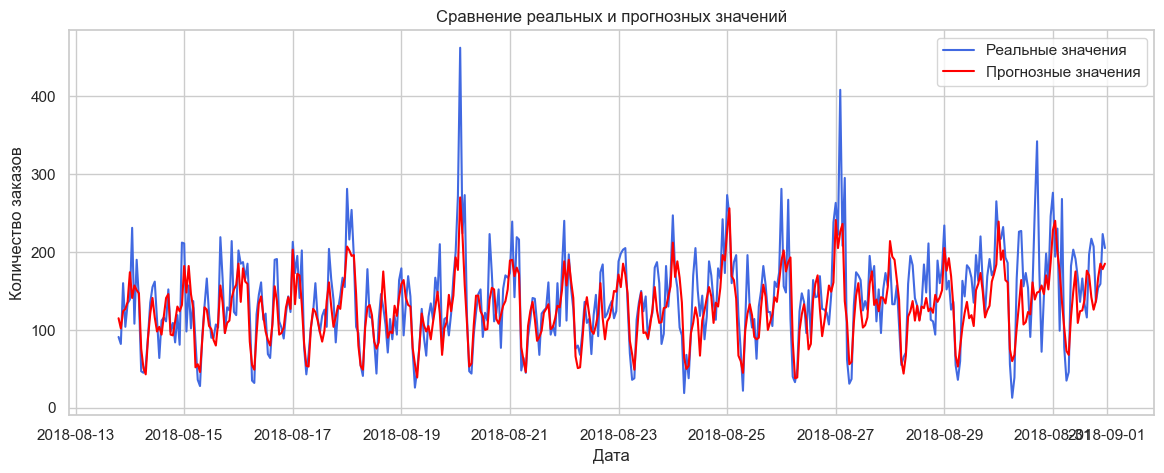

In [29]:
# Датафрейм с реальными и прогнозными значениями
y_test_pred = pd.DataFrame({'y_test': y_test})
y_test_pred['y_pred'] = y_pred.astype(np.int32)

# График
plt.figure(figsize=(14, 5))
sns.lineplot(data=y_test_pred, x=y_test_pred.index, y='y_test', label='Реальные значения', color='royalblue', linestyle='-')
sns.lineplot(data=y_test_pred, x=y_test_pred.index, y='y_pred', label='Прогнозные значения', color='red', linestyle='-')
plt.title('Сравнение реальных и прогнозных значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Несмотря на наличие отклонений в отдельных моментах (пики, которые мы рассмотрели на этапе анализа), в целом график показывает, что модель прогнозирования хорошо справляется с задачей.

#### Проверка адекватности модели

После выбора лучшей модели, важно оценить её адекватность. Для этого сравним результаты лучшей модели с прогнозом константой (DummyRegressor) и прогнозом предыдущим значением ряда. Это позволит понять, насколько предсказания сложной модели лучше базового решения.

In [30]:
# Обучение модели DummyRegressor
dummy_regr = DummyRegressor(strategy = 'median')
dummy_regr.fit(X_train, y_train)

# Прогноз константой
y_dummy_pred = dummy_regr.predict(X_test)
rmse_dummy = mean_squared_error(y_test, y_dummy_pred, squared=False)

# Прогноз предыдущим значением
y_previous_pred = y_test.shift()
y_previous_pred.iloc[0] = y_train.iloc[-1]
rmse_previous = mean_squared_error(y_test, y_previous_pred, squared=False)

# Вывод результатов
print(f'RMSE DummyRegressor: {rmse_dummy:.4f}')
print(f'RMSE прогноза предыдущим значением: {rmse_previous:.4f}')
print(f'Разница между CatBoostRegressor и DummyRegressor: {rmse_test - rmse_dummy:.4f}')
print(f'Разница между CatBoostRegressor и прогнозом предыдущим значением: {rmse_test - rmse_previous:.4f}')

RMSE DummyRegressor: 87.3589
RMSE прогноза предыдущим значением: 59.0190
Разница между CatBoostRegressor и DummyRegressor: -48.2488
Разница между CatBoostRegressor и прогнозом предыдущим значением: -19.9090


Это подтверждает, что использование более сложной модели, такой как CatBoostRegressor, оправдано, и она значительно лучше базовых методов предсказания.

## Общий вывод

В ходе проведенного исследования были выполнены следующие этапы и получены следующие основные результаты.

1) **Обработка данных**
- Провели ресемплирование данных по одному часу.
- Выявили, что данные монотонны.
- Были проверены пропущенные значения, а также дубликаты. Их не обнаружили
***
2) **Исследовательский анализ данных**
- Распределение заказов такси в час смещенное нормальное, с медианным значением в 84 заказа.
- С марта по май количество заказов стабильно и колеблется в диапазоне 50-75 заказов. С мая по август наблюдается планомерный рост до 100-125 заказов. В агусте резкий рост до значений в 150-175 заказов.
- В течение дня пиковые значения заказов приходятся на ночь (01:00-02:00).
- Выделены случайные колебания в конце августа, вероятно, из-за увеличения числа туристов.
- Проведен тест Дики-Фуллера (ADF), который подтвердил стационарность временного ряда.
***
3) **Обучение модели**

Было создано 35 признаков временного ряда: календарные, лаговые, цикличные и скользящие средние.

Для масштабирования числовых признаков был использован StandardScaler. Для подбора наилучших гиперпараметров для каждой модели был использован OptunaSearchCV.

В результате было обучено 5 моделей: **Lasso Regression**, **Ridge Regression,  Random Forest Regressor, LGBMRegressor** и **CatBoostRegressor**. Для каждой модели рассчитана метрика RMSE.
***
4) **Анализ результатов**

Наилучшее качество предсказаний с наименьшим значением RMSE (23.9301) показала **CatBoostRegressor**. На тестовой выборке показатель RMSE составил **39.1100**, т.е. удовлетворяющий критерию.

Также модель была проверена на адекватность 2 способами (прогнозом константой и прогнозом предыдущим значением ряда). Результаты показали, что использование более сложной модели CatBoostRegressor оправдано, и она значительно лучше базовых методов предсказания.
***
5) **Итоги исследования**
- В ходе исследования была построена модель для предсказания количества заказов такси на следующий час, что позволит привлекать больше водителей в периоды пиковой нагрузки.
- Наилучшие результаты по качеству предсказания продемонстрировала модель **CatBoostRegressor** с показателем RMSE 39.1100 на тестовой выборке. Эта модель соответствует критериям проекта и показывает удовлетворительный уровень точности.